# Differential reddening correction of M22

Research project for the course of **Stellar Astrophysics**. 

**Students**: Aggio Giada (2089092), Merola Mattia (2090208)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

## The reddenend CMD
We read the data and select only the ones that don't present saturated values.

In [2]:
df= pd.read_fwf('M22xymag.txt', delimiter='')

Flag the values with errors (like mag 99.999, saturated).

In [3]:
# add new column of ones as flag
flag = np.ones(len(df))
df['flag'] = flag

# change flag to 0 if F438W or F814W is saturated
df.loc[(df['F438W'] > 99) | (df['F814W'] > 99), 'flag'] = 0

# select flagged data
data = df[df['flag' ] == 1.0]

# drop the comlumns we won't use
data = data.drop(columns=['F275W', 'F336W', 'flag'])
data.head()

,X,Y,F438W,F814W
51,5014.9339,2728.0915,20.8330,18.4599
58,5004.3502,2738.0061,21.2302,18.8189
60,4840.0632,2738.7483,18.4868,16.6370
67,4871.0463,2744.5071,21.9568,19.3370
69,5118.3920,2746.8604,20.3204,18.2079


In [4]:
data.loc[:, 'Color'] = data['F438W'] - data['F814W']
data.loc[:, 'Magnitude'] = data['F814W']

data.head()

,X,Y,F438W,F814W,Color,Magnitude
51,5014.9339,2728.0915,20.8330,18.4599,2.3731,18.4599
58,5004.3502,2738.0061,21.2302,18.8189,2.4113,18.8189
60,4840.0632,2738.7483,18.4868,16.6370,1.8498,16.6370
67,4871.0463,2744.5071,21.9568,19.3370,2.6198,19.3370
69,5118.3920,2746.8604,20.3204,18.2079,2.1125,18.2079


Plot the CMD affected by reddening. 

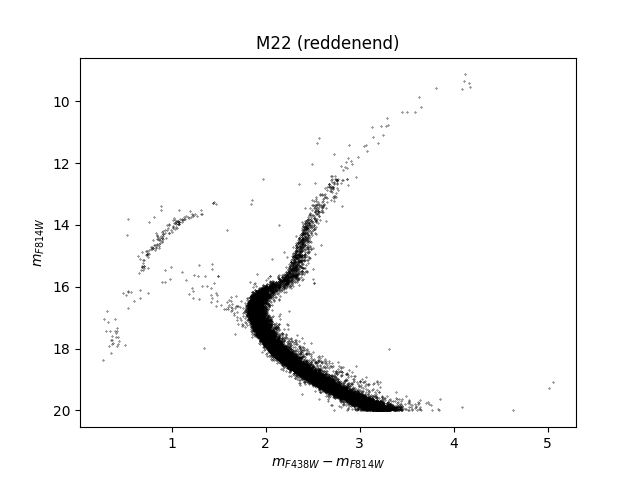

In [5]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('M22 (reddenend)')
plt.show()

M22 presents a CMD moderately affected by differential reddening, there is no need for proper motion correction since there is very small contamination. 

## Differential reddening correction

### Reddening vector
Now we have to find the direction of the reddening so we need to plot the reddening vector. As we did before we have that the slope of the reddening vector is given by 
$$
\text{Slope} = \frac{R_{F814W}}{R_{F438W}-R_{F814W}}
$$
where $R_{F814W} = A_{F814W}/E/(B-V) = 1.86$ (I band) and $R_{F438W} = A_{F438W}/E/(B-V) = 4.18$ (B band). 

In [6]:
R_B = 4.18          # R_F438W     R_B
R_I = 1.86          # R_F814W     R_I

# plot the reddening vector
slope = (R_I)/(R_B-R_I)
E_BV = 0.2
delta_BI = (R_B-R_I)*E_BV
delta_I = R_I*E_BV

color_0 = 2.5
mag_0 = 17

color_1 = color_0 + delta_BI  
mag_1 = mag_0 + delta_I

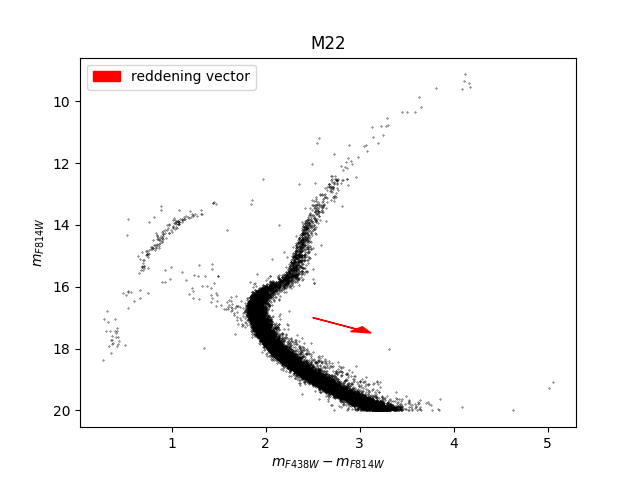

In [7]:
# plot reddening vector as an arrow
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.arrow(color_0, mag_0, color_1-color_0, mag_1-mag_0, head_width=0.2, head_length=0.2, fc='red', ec='red', label='reddening vector')
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('M22')
plt.show()

### Reddening correction
Going on with the differential reddening correction we first divide the field of view in sectors. 

In [8]:
n_sectors_x = 50  # Number of sectors along x
n_sectors_y = 50  # Number of sectors along y
x_bins = np.linspace(data['X'].min(), data['X'].max(), n_sectors_x+1)
y_bins = np.linspace(data['Y'].min(), data['Y'].max(), n_sectors_y+1)

# assign a sector to each data point
data['Sector'] = -1
sector_colors = []

for i in range(n_sectors_x):
    for j in range(n_sectors_y):
        sector_index = i * n_sectors_y + j
        sector_colors.append(sector_index)
        sector_data = (data['X'] >= x_bins[i]) & (data['X'] < x_bins[i+1]) & \
                      (data['Y'] >= y_bins[j]) & (data['Y'] < y_bins[j+1])
        data.loc[sector_data, 'Sector'] = sector_index

data.head()

,X,Y,F438W,F814W,Color,Magnitude,Sector
51,5014.9339,2728.0915,20.8330,18.4599,2.3731,18.4599,1100
58,5004.3502,2738.0061,21.2302,18.8189,2.4113,18.8189,1100
60,4840.0632,2738.7483,18.4868,16.6370,1.8498,16.6370,1050
67,4871.0463,2744.5071,21.9568,19.3370,2.6198,19.3370,1050
69,5118.3920,2746.8604,20.3204,18.2079,2.1125,18.2079,1150


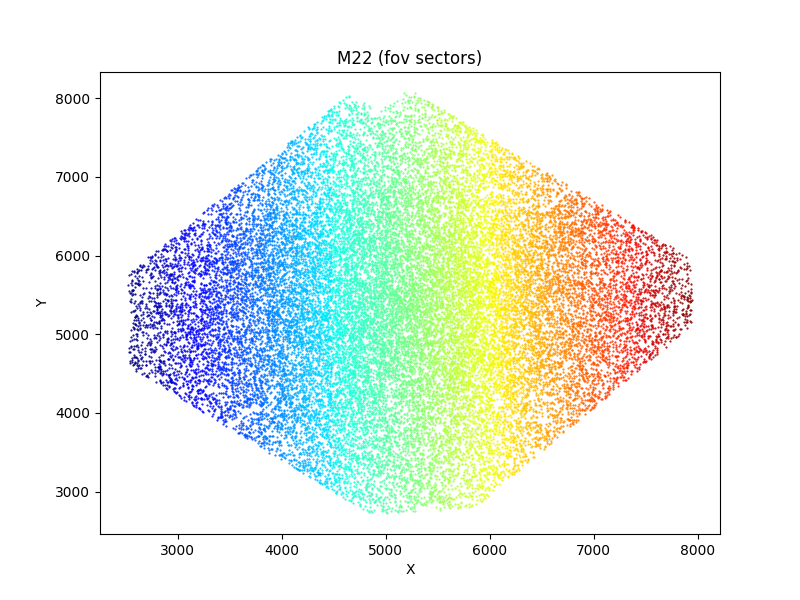

In [9]:
# plot the sensor sectors with different colors
plt.figure(figsize=(8, 6))
colors = plt.cm.jet(np.linspace(0, 1, n_sectors_x * n_sectors_y))

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['X'], sector_data['Y'], color=colors[sector_index], s=0.3, label=f'Sector {sector_index}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('M22 (fov sectors)')
plt.show()

Now we plot the CMD for each sector (in the same plot, the color of the CMD is the same as the color of the sector in the sensor). 

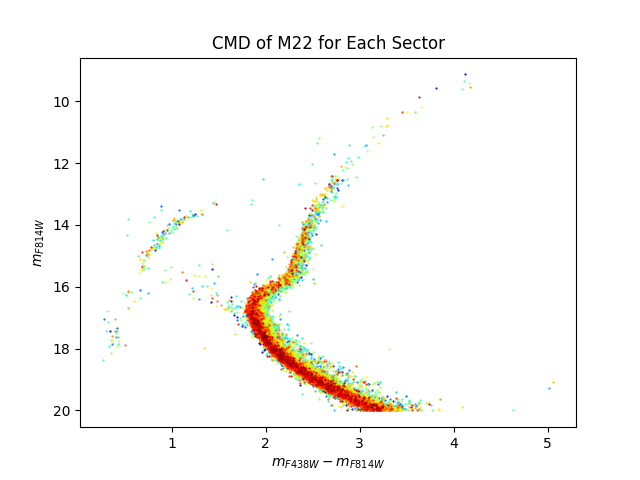

In [10]:
# plot the CMD for all sectors on the same figure
plt.figure()

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F438W'] - sector_data['F814W'], sector_data['F814W'], color=colors[sector_index], s=0.3)

plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('CMD of M22 for Each Sector')
plt.show()

We then select a small region in the main sequence that we'll use later to compute the color excess. 

In [11]:
mag_lo = 18
mag_hi = 18.1 
col_lo = 1.8
col_hi = 2.6

ms_data = data[(data['F814W'] > mag_lo)
             & (data['F814W'] < mag_hi)
             & (data['F438W'] - data['F814W'] > col_lo) 
             & (data['F438W'] - data['F814W'] < col_hi)]

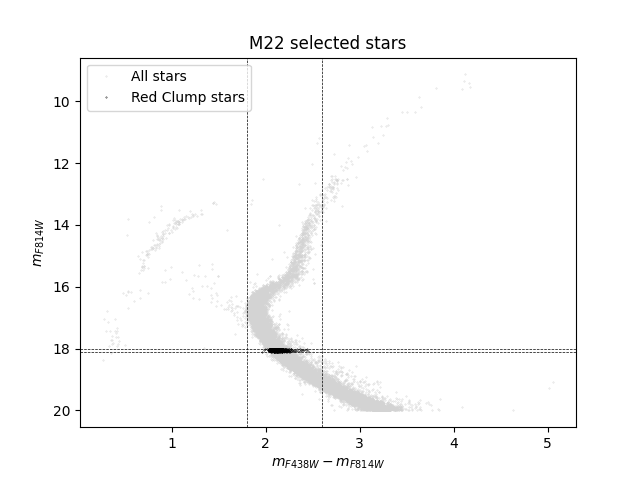

In [12]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='lightgrey', label='All stars')
plt.plot(ms_data['Color'], ms_data['Magnitude'], 'o', markersize=0.3, color='black', label='Red Clump stars')
plt.axhline(y=mag_lo, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=mag_hi, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=col_lo, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=col_hi, color='k', linestyle='--', linewidth=0.5)

plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('M22 selected stars') 
plt.show()

For each sector we compute the mean point for the selected MS stars.

In [13]:
# Calculate the mean point of MS stars for each sector
mean_points = []
color_excesses = []
mag_excesses = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_ms_data = ms_data[ms_data['Sector'] == sector_index]
    if not sector_ms_data.empty:
        mean_color = (sector_ms_data['F438W'] - sector_ms_data['F814W']).mean()
        mean_mag = sector_ms_data['F814W'].mean()
        mean_points.append((mean_color, mean_mag))
    else:
        mean_points.append((np.nan, np.nan))

Now we look for the sector with the lowest standard deviation and we take it as reference sector. This sector represents the one less affected by reddening.

In [14]:
# compute the sector with the lowest standard deviation
stds = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_ms_data = ms_data[ms_data['Sector'] == sector_index]
    if not sector_ms_data.empty:
        std = (sector_ms_data['F438W']-sector_ms_data['F814W']).std()
        stds.append(std)
    else:
        stds.append(np.nan)

min_std_sector = np.nanargmin(stds)
print(f'Sector with the lowest standard deviation: {min_std_sector}')

Sector with the lowest standard deviation: 2033


At this point we compute, for each sector, the difference between its mean point and the mean point of the reference sector. This difference represent the **color excess** and the **magnitude excess**. 

Once we have done that we can plot the **corrected CMD** simply subtracting the color excess and the mag excess from the color index and the magnitude, respectively.

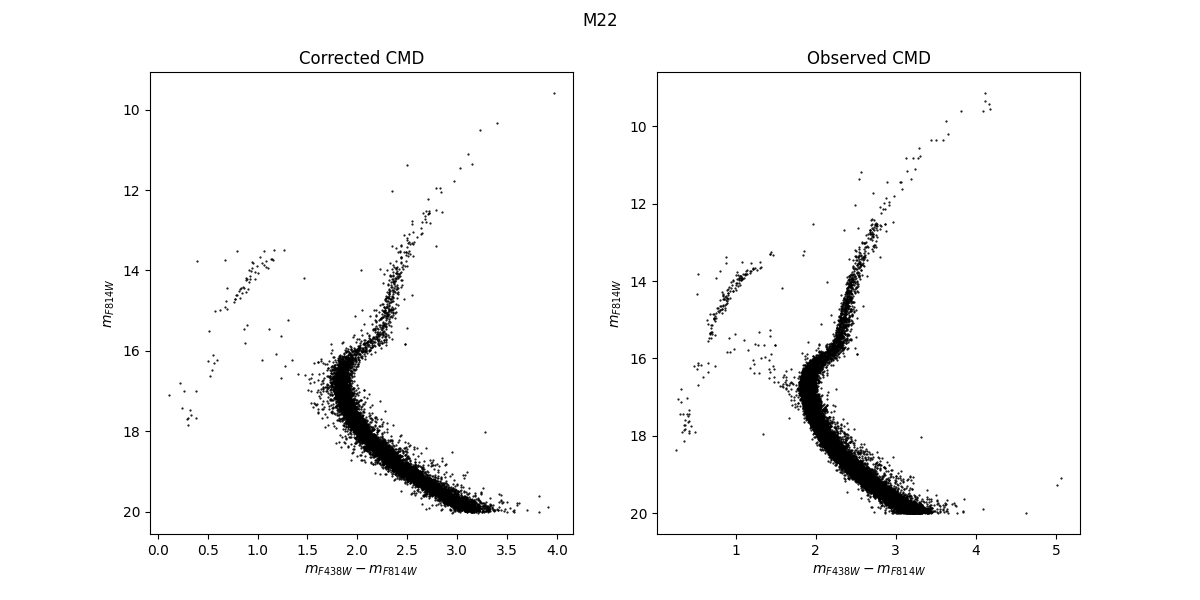

In [15]:
# compute for each sector the difference between the mean point and the minimum standard deviation sector
for sector_index in range(n_sectors_x * n_sectors_y): 
    color_excess = mean_points[sector_index][0] - mean_points[min_std_sector][0]
    mag_excess = mean_points[sector_index][1] - mean_points[min_std_sector][1]
    color_excesses.append(color_excess)
    mag_excesses.append(mag_excess)

# plot the CMD for all sectors on the same figure
plt.figure(figsize=(12,6))
plt.suptitle('M22')

plt.subplot(121)
for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F438W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color='black', s=0.3)
    
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Corrected CMD')

plt.subplot(122)
plt.scatter(data['F438W'] - data['F814W'], data['F814W'], color='black', s=0.3)
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Observed CMD')

plt.show()


To see the difference between the corrected CMD and the original one we can plot them in the same figure. The black CMD is the original one, the colored one is the corrected.  

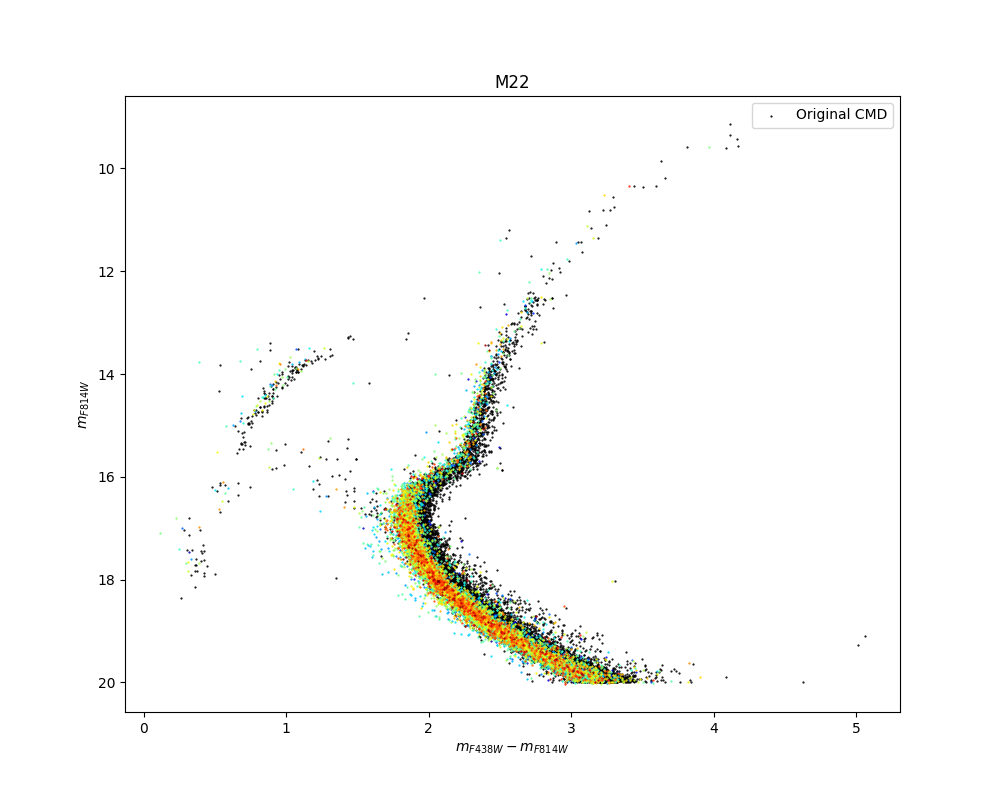

In [16]:
# compare the corrected CMD with the one affected by differential reddening on the same plot
plt.figure(figsize=(10, 8))

plt.scatter(data['F438W'] - data['F814W'], data['F814W'], color='black', s=0.3, label='Original CMD')

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F438W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color=colors[sector_index], s=0.3)
    
plt.gca().invert_yaxis()
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend()
plt.title('M22')
plt.show()

To verify our correction we can plot the CMD of the main sequence only. 

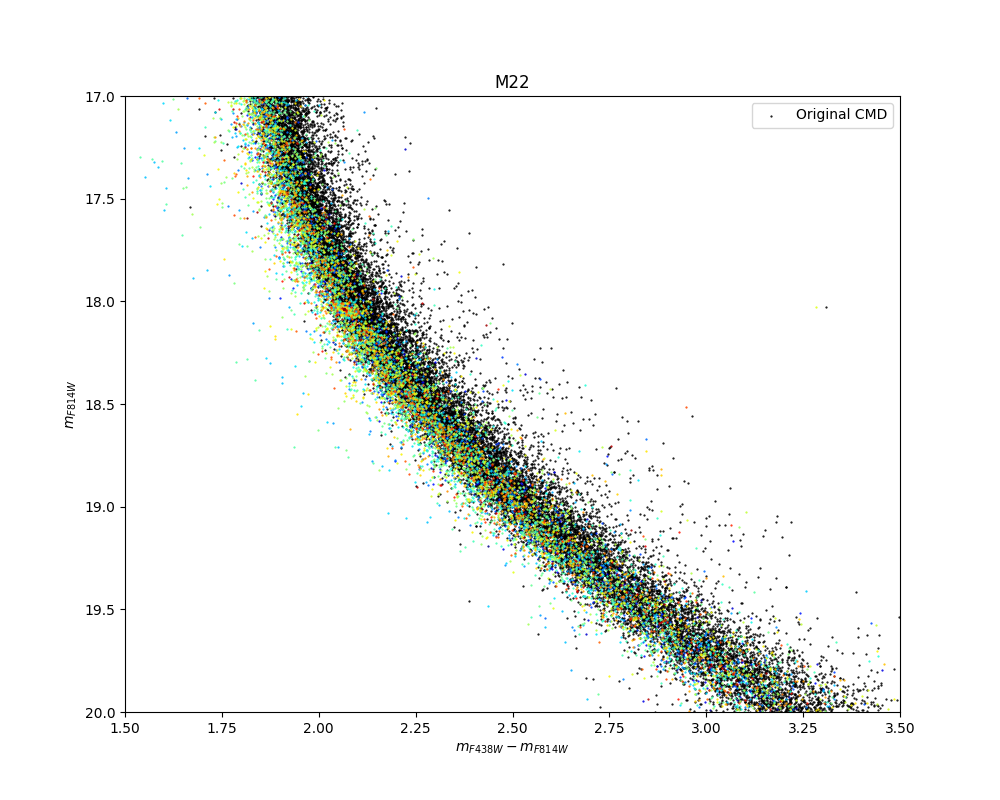

In [17]:
plt.figure(figsize=(10, 8))

plt.scatter(data['F438W'] - data['F814W'], data['F814W'], color='black', s=0.3, label='Original CMD')

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F438W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color=colors[sector_index], s=0.3)
    
plt.gca().invert_yaxis()
plt.xlim(1.5,3.5)
plt.ylim(20,17)
plt.xlabel(r'$m_{F438W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend()
plt.title('M22')
plt.show()

Here we see that the original CMD (black points) is more broadened than the corrected one (colored points) which indicates that our method is somehow correct. 